# 1.1 - Our First Computer Vision Application (Motion Detection)

A simple computer vision application is motion detection in a video recorded by a fixed camera. Security cameras and doorbell cameras use motion detection to detect when someone is entering the field of view of the camera.

Motion detection can be achieved using a simple computer vision technique known as *frame differencing*. This can be done by computing video frame differences.

Let's load a short video.

In [2]:
from IPython.display import Video
Video('./data/Illinois_highway.mp4', width=350)

Next, we will use OpenCV to capture individual frames from the video.

In [3]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load a video
cap = cv.VideoCapture('./data/Illinois_highway.mp4')

First let's find out what the frame rate (frames per second) of the video is, how many total frames are there in the video, and what is the resolution of the video.

In [38]:
# Get the frame rate of the video
frame_rate = cap.get(cv.CAP_PROP_FPS)
print('Frame rate:', frame_rate)

# Count the total number of frames in the video
length = int(cap. get(cv. CAP_PROP_FRAME_COUNT))
print('Number of frames in the video:', length)

# Get the width and height of the video
width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
print('Width:', width)
print('Height:', height)


Frame rate: 29.96969696969697
Number of frames in the video: 69
Width: 1920
Height: 1080


As we can see, the frame rate is ~30 fps, which is a common frame rate for regular cameras. 

Next, let's extract a frame from the video.

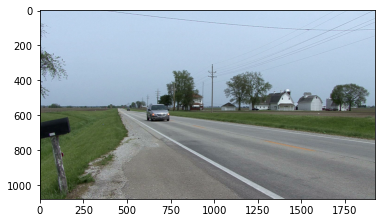

In [5]:
# Extract the first frame of the video
ret, frame = cap.read()

# Convert the grame to RGB color space
frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)

# Show the first frame
plt.imshow(frame)

The function `read()` returns `True` if an image was extracted successfully extracted from the video, and the image (frame) itself. It returns `False` and an empty image if no images was extracted, e.g. because the camera has been disconnected, or there are no more frames in video file.

Let's now try to detect where the moving vehicle is. To do so, we find the part of the image that exhibits the highest amount of motion. We can detect motion by subtracting neighboring frames from each other. Pixes in which motion does not occur will have more or less the same values in neighboring frames. Thus subtracting a frame from another will result in a difference close to zero for those pixels. However, for pixels in which motion occurs, the pixels values will have changed significantly between neighboring frames, therefore there difference is going to be non-zero. 

Let's observe this technique in practice. Although the same tricks can be applied to color images, for simplicity we will work with grayscale images from now on.

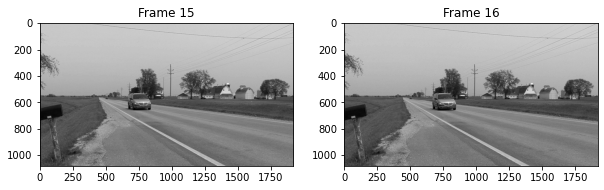

In [6]:
# Extract frame number 15 from the video
cap.set(cv.CAP_PROP_POS_FRAMES, 15)
ret, frame15 = cap.read()
# Convert the frame to gray scale
frame15 = cv.cvtColor(frame15, cv.COLOR_BGR2GRAY)

# Repeat the same for frame number 16
cap.set(cv.CAP_PROP_POS_FRAMES, 16)
ret, frame16 = cap.read()
# Convert the frame to gray scale
frame16 = cv.cvtColor(frame16, cv.COLOR_BGR2GRAY)

# Show the two frames
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1),plt.imshow(frame15, cmap='gray'),plt.title('Frame 15') # Show the image in grayscale
plt.subplot(1, 2, 2),plt.imshow(frame16, cmap='gray'),plt.title('Frame 16')
plt.show()

We cannot tell much of a difference in the two frames, but let's observer what happens when we take their difference. We will use the function `absdiff`, which takes the absolute value of each pixel difference so that we do not end up with negative value pixels.

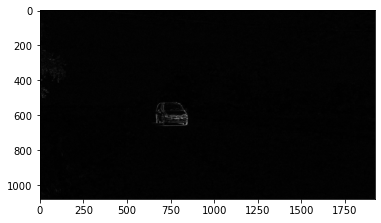

In [7]:
diff = cv.absdiff(frame15, frame16)
plt.imshow(diff, cmap='gray')

We can observe some non-black pixels. Those are the pixels for which the difference was significantly greater than zero. To take a closer look at those values, we can zoom into a small region of the image: 

In [8]:
# Print a patch of the frame difference matrix
print(diff[610:630, 840:855])

[[  8   6   7  20  45  49  24   6   2   1   7  10   3   5   4]
 [ 11  23  27  33  50  38  24  11   9   0   3   3   3   3   2]
 [ 31  36  29  47  58  71  59  34   9   6   5  14  15  12   4]
 [ 19   2  39  44  47  56  43  26  11  27  28  18   5   5  10]
 [ 47  36  38  37  42  25   3   1   2   4   0   4   9   3   4]
 [ 39  39  40  46  38  18  54  44  23   5   2   2  15   1   4]
 [ 90 114 117 119 119 120 102  69  23   3   7   4   8  12  11]
 [ 96 123 124 122 122 121 100  62  22   2   2   8  12   4   6]
 [127 136 141 133 136 121  96  60  17   7   8   3   2   1   4]
 [144 150 136 141 132 129 101  57  17  12  17  12  13   7   1]
 [130 145 147 150 136 140 118  69  25   2  11   7  15   3   2]
 [104  98 101 118  96 100  86  55  25   7   5  10   4   7   1]
 [ 69  66  55  55  58  58  58  39   9   1   3   0   0   1   4]
 [ 32  47  46  46  52  50  44  34  12   5   9  11   7  10   7]
 [ 31  38  38  40  56  52  49  32  10   6  10   5   7   7   2]
 [ 42  45  48  50  66  65  46  29   9   1   4   6   5  

This effect will be more pronounced if we take two frames that are farther apart from each other.

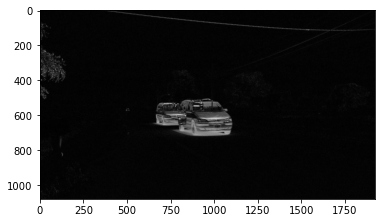

In [9]:
# Extract frame number 35 from the video
cap.set(cv.CAP_PROP_POS_FRAMES, 35)
ret, frame35 = cap.read()
# Convert the frame to gray scale
frame35 = cv.cvtColor(frame35, cv.COLOR_BGR2GRAY)

diff = cv.absdiff(frame15, frame35)
plt.imshow(diff, cmap='gray')

The above frame shows as much motion information about frame 15 as it does about frame 35, which effectively shows the car in two different positions. What if we wanted to only show the motion pixels of frame 15 but not of frame 35? 

To do that we will use two frames of equal distance from frame 15. Those can be frames 5 and 25 (or 10 and 20, etc.). We will calculate the frame difference between each one of them and frame 15, and then we will extract the motion pixels that are common between those two differences.

To extract the motion pixels that are common between the two differences, we will use the function `min()` to take them minimum value of each pixel between the two diff matrices. The motion pixels that correspond to frame 15, will be the same in the two matrices. However, the motion pixels which come from frame 5, will be have a much smaller value in the diff matrix that captures the motion of frames 15 and 25, and vice versa. Therefore by selecting the minimum of each pixel, we end up keeping only the motion pixels that come from frame 15.

Note: to avoid having to deal with edge cases, e.g. where one of the frames ends up being outside of the video limits (e.g. a number smaller than 0 or greater than 69) we will only work with frames that not in the two ends of the video.

Let's try this in practice.

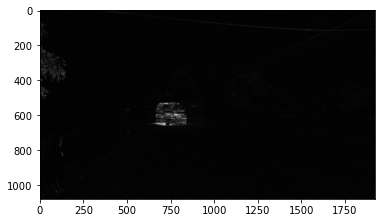

In [10]:
# Extract frame number 5 from the video
cap.set(cv.CAP_PROP_POS_FRAMES, 5)
ret, frame5 = cap.read()
# Convert the frame to gray scale
frame5 = cv.cvtColor(frame5, cv.COLOR_BGR2GRAY)

# Extract frame number 15 from the video
cap.set(cv.CAP_PROP_POS_FRAMES, 15)
ret, frame15 = cap.read()
# Convert the frame to gray scale
frame15 = cv.cvtColor(frame15, cv.COLOR_BGR2GRAY)

# Extract frame number 25 from the video
cap.set(cv.CAP_PROP_POS_FRAMES, 25)
ret, frame25 = cap.read()
# Convert the frame to gray scale
frame25 = cv.cvtColor(frame25, cv.COLOR_BGR2GRAY)

diff1 = cv.absdiff(frame5, frame15)
diff2 = cv.absdiff(frame15, frame25)

motion = cv.min(diff1, diff2)   # Take the minimum of the two differences
plt.imshow(motion, cmap='gray')

### Thresholds

As you can notice the pixel values can range from 0 to 255. If we do not care about the exact value of each pixel but we just want to know which pixels are greater than a certain value, we can set a threshold on the diff matrix. 

In Python we can simply apply the mathematical operator `>` (grater) directly on a matrix and the result will be a matrix of the same size with each value replaced with `True` or `False` depending of that corresponding value was greater than the threshold or not.

The `imshow()` function is smart enough to be able to display a matrix even when the pixel values are binary. The True values are mapped to 255 and the False values are mapped to 0.

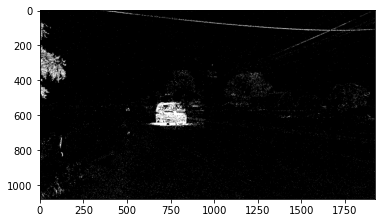

In [29]:
binary_img = motion > 10        # Threshold the image
plt.imshow(binary_img, cmap='gray')

Let's print out a small patch to look inside.

In [30]:
print(binary_img[620:630, 800:810])

[[ True  True False False  True  True  True  True  True  True]
 [ True False False  True  True  True  True  True  True  True]
 [False False False  True False False  True  True  True  True]
 [ True  True  True  True  True  True  True False  True  True]
 [ True  True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True]
 [ True  True False False False False False False False False]
 [ True  True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True]]


OpenCV provides it's own function for applying a threshold to an image. The OpenCV function `threshold()` returns a numeric matrix where values below the threshold become and 0s and values over the threshold become `maxval`, where maxval is a number provided as input to the function. We will use this function from now on as some other OpenCV functions can only work with numeric matrices and not boolean ones. Note that the function `threshold()` provides functionality for automatically detecting the optimal threshold. We will manually pick our thresholds for now.


In [33]:
thresh, binary_img = cv.threshold(motion, thresh = 10, maxval = 255, type = cv.THRESH_BINARY)
print(binary_img[620:630, 800:810])

[[255 255   0   0 255 255 255 255 255 255]
 [255   0   0 255 255 255 255 255 255 255]
 [  0   0   0 255   0   0 255 255 255 255]
 [255 255 255 255 255 255 255   0 255 255]
 [255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255]
 [255 255   0   0   0   0   0   0   0   0]
 [255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255]]


In the displayed binary motion image above, we can see the car pixels, but also a few pixels on the left of the picture, which are the leaves of a tree, probably moving because of the wind.

Now let's try a few different threshold values and see how our output looks.

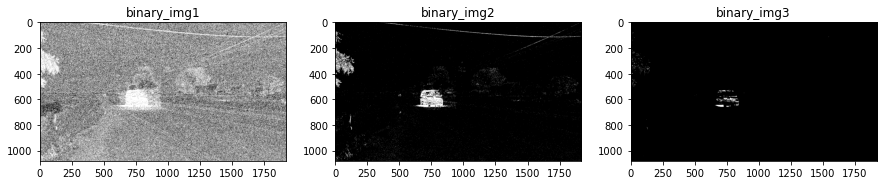

In [39]:
thresh, binary_img1 = cv.threshold(motion, thresh = 1, maxval = 255, type = cv.THRESH_BINARY) 
thresh, binary_img2 = cv.threshold(motion, thresh = 10, maxval = 255, type = cv.THRESH_BINARY)
thresh, binary_img3 = cv.threshold(motion, thresh = 60, maxval = 255, type = cv.THRESH_BINARY)

plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1),plt.imshow(binary_img1, cmap='gray'),plt.title('binary_img1') # Show the image in grayscale
plt.subplot(1, 3, 2),plt.imshow(binary_img2, cmap='gray'),plt.title('binary_img2')
plt.subplot(1, 3, 3),plt.imshow(binary_img3, cmap='gray'),plt.title('binary_img3')
plt.show()

Setting a threshold of 1 returns too many white pixels, which is the result of the camera noise in the image. A threshold value 60 seems to miss a lot of the pixels of the car. A threshold value of 10 seems to be a good choice.

The next question is, how can detect the car? One way to that is to find all the pixels that belong to the car and then calculate their center. The first step of that process is to find the pixels that belong to the car. 

As we see in the displayed motion image, besides the pixels that belong to the car, there are other white pixels as a result of motion in the background (e.g. tree leaves). To keep only the car motion pixels and get rid of all other white pixels, we will find the largest connected component in the image. A [**connected component**](https://en.wikipedia.org/wiki/Connected-component_labeling) is a consecutive set of white pixels which are adjacent to other white pixels. We can assume that since the car is the object exhibiting the highest motion in the image, that will be the largest component. To get all the connected components in the image we will use the OpenCV function `connectedComponentsWithStats()`.

For details about function `connectedComponentsWithStats()`, please refer to the documentation:
https://docs.opencv.org/4.6.0/d3/dc0/group__imgproc__shape.html#gae57b028a2b2ca327227c2399a9d53241

```
function connectedComponentsWithStats():
params:
- binary_img: the thresholded binary image
- connectivity: 8 or 4 for 8-way or 4-way connectivity respectively.
return:
- nb_components returns the number of connected components in the image.
- output returns the labelled image.
- stats returns statistics about the bounding box of each component.
- centroids returns the centroid of each component.
```

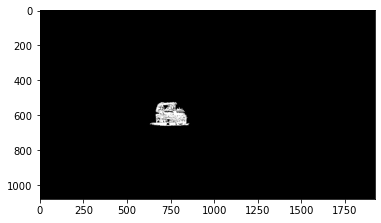

In [34]:
# Threshold the image
thresh, binary_img = cv.threshold(motion, thresh = 10, maxval = 255, type = cv.THRESH_BINARY)

# Find the connected components
nb_components, output, stats, centroids = cv.connectedComponentsWithStats(binary_img, connectivity=4)

# Find the largest non background component.
# Note: range() starts from 1 since 0 is the background label.
max_label, max_size = max([(i, stats[i, cv.CC_STAT_AREA]) for i in range(1, nb_components)], key=lambda x: x[1])

# Keep only the largest component.
binary_img[output != max_label] = 0

# Show the result.
plt.imshow(binary_img, cmap='gray')

Now we have a clean motion image with only the car pixel set to non-zero, although the shadow of the car also captured. To find the center of the car we can calculate the average horizontal and vertical positions of all non-zero pixels by wring our own code, or we can easily access it int the centroid values that the function `connectedComponentsWithStats()` returns.

In [35]:
# Find the centroid of the largest component.
centroid = centroids[max_label]

# print the centroid
print(centroid)

[744.755154   602.87611773]


The centroid values correspond to the horizontal (x) and vertical (y) coordinates in the image, counting from the top-left corner. The coordinates are calculated as floating point numbers. To map to pixel positions, we need convert the numbers to integers. Let's get those pixel positions and draw red dot on top of the motion image so we can see it.

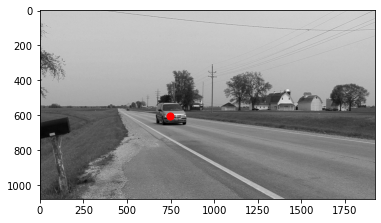

In [26]:
centroid_row = int(centroid[1])         # y-coordinate
centroid_col = int(centroid[0])         # x-coordinate

# Draw the centroid on the image
plt.imshow(frame15, cmap='gray')
plt.scatter(centroid_col, centroid_row, c='r', s=50)
plt.show()

We can also draw a bounding box around the car.

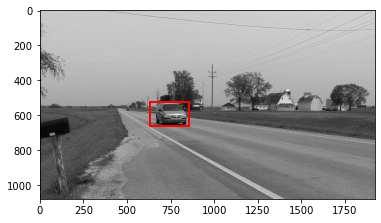

In [36]:
# Draw bounding box around the largest component
# Note: The bounding box is defined by the x, y coordinates of the top left corner and the width and height of the box.
left = int(stats[max_label, cv.CC_STAT_LEFT])
top = int(stats[max_label, cv.CC_STAT_TOP])
width = int(stats[max_label, cv.CC_STAT_WIDTH])
height = int(stats[max_label, cv.CC_STAT_HEIGHT])

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(frame15, cmap='gray')

# Create a Rectangle patch
import matplotlib.patches as patches
rect = patches.Rectangle((left, top), width, height, linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()